# About this Notebook

The goal of this notebook is to build a classifier using a BERT pre-trained model to find toxic comments. The data has been taken from a series of Kaggle competitions to classify Wikipedia comments as toxic/nontoxic. The data has been sourced from Google and Jigsaw. 

Though the full dataset includes non-English comments, I will restrict myself to English-only comment for this iteration. 

For metrics, I will focus on both ROC and precision-recall curves. In addition, I will look at the confusion matrix and performance across different flavors of toxicity.

Credits:
- https://www.kaggle.com/tanulsingh077/deep-learning-for-nlp-zero-to-transformers-bert
- https://www.kaggle.com/jagangupta/stop-the-s-toxic-comments-eda
- https://www.kaggle.com/clinma/eda-toxic-comment-classification-challenge
- https://www.kaggle.com/abhi111/naive-bayes-baseline-and-logistic-regression

In [31]:
import numpy as np
import pandas as pd 
from collections import defaultdict as ddict, Counter
from tqdm import tqdm
from scipy.sparse import csr_matrix, hstack
from sklearn import metrics
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import re

import random
import string

pd.options.display.max_rows = 999

In [32]:
from toxicity import constants, data, features, text_preprocessing, model, metrics, visualize


## Load data

In [3]:
input_data_path = './../'+constants.INPUT_PATH
df_train = data.load(input_data_path, filter=False)

In [5]:
xtrain, xvalid, ytrain, yvalid = model.make_train_test(df_train)

In [6]:
len(xvalid)

44710

## Transformers/Attention/BERT

In [35]:
# Loading Dependencies
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import Accuracy, AUC
#from kaggle_datasets import KaggleDatasets
import transformers

from tokenizers import BertWordPieceTokenizer

Encoder FOr DATA for understanding waht encode batch does read documentation of hugging face tokenizer :
https://huggingface.co/transformers/main_classes/tokenizer.html here

In [36]:
#IMP DATA FOR CONFIG
AUTO = tf.data.experimental.AUTOTUNE

# Configuration
EPOCHS = 3
BATCH_SIZE = 16 
MAX_LEN = 512

In [37]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=MAX_LEN):
    """
    Encoder for encoding the text into sequence of integers for BERT Input
    """
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(length=maxlen)
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

## Tokenization

For understanding please refer to hugging face documentation again

In [38]:
# First load the real tokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-cased')
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=False)
fast_tokenizer

Tokenizer(vocabulary_size=28996, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=False, wordpieces_prefix=##)

In [39]:
x_train = fast_encode(xtrain.astype(str), fast_tokenizer, maxlen=MAX_LEN)
x_valid = fast_encode(xvalid.astype(str), fast_tokenizer, maxlen=MAX_LEN)
#x_test = fast_encode(test.content.astype(str), fast_tokenizer, maxlen=MAX_LEN)

y_train = ytrain
y_valid = yvalid

100%|██████████| 175/175 [00:05<00:00, 33.23it/s]


In [41]:
#Testcase
fast_tokenizer.id_to_token(12242)


'cubic'

In [42]:
def sample(input, n=50):
    return input[0:n]

x_train_s = sample(x_train)
x_valid_s = sample(x_valid)
y_train_s = sample(y_train)
y_valid_s = sample(y_valid)

In [51]:
def build_model(transformer, max_len=MAX_LEN):
    """
    function for training the BERT model
    """
    input_word_ids = Input(shape=(max_len,), dtype='int32', name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

## Starting Training

If you want to use any another model just replace the model name in transformers._____ and use accordingly

In [52]:
%%time

transformer_layer = (
    transformers.TFDistilBertModel
    .from_pretrained('distilbert-base-cased')
)
model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'activation_13', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-cased.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 512)]             0         
_________________________________________________________________
tf_distil_bert_model_3 (TFDi ((None, 512, 768),)       65190912  
_________________________________________________________________
tf_op_layer_strided_slice_3  [(None, 768)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 769       
Total params: 65,191,681
Trainable params: 65,191,681
Non-trainable params: 0
_________________________________________________________________
CPU times: user 4.21 s, sys: 1.33 s, total: 5.54 s
Wall time: 4.15 s


In [45]:
n_steps = x_train_s.shape[0] // BATCH_SIZE
n_steps

3

In [53]:
n_steps = x_train_s.shape[0] // BATCH_SIZE
train_history = model.fit(
    x_train_s,
    y_train_s,
    batch_size=BATCH_SIZE,
    validation_data=(x_valid_s, y_valid_s),
    epochs=EPOCHS
)

Epoch 1/3
4/4 [==============================] - 146s 36s/step - loss: 0.3957 - accuracy: 0.9200 - val_loss: 0.4166 - val_accuracy: 0.8600
Epoch 2/3
4/4 [==============================] - 172s 43s/step - loss: 0.2965 - accuracy: 0.9200 - val_loss: 0.4065 - val_accuracy: 0.8600
Epoch 3/3
4/4 [==============================] - 176s 44s/step - loss: 0.2859 - accuracy: 0.9200 - val_loss: 0.4097 - val_accuracy: 0.8600


In [54]:
y_pred=model.predict(
    x_valid_s
)

Average precision-recall score: 0.14
[[43  0]
 [ 7  0]]
Accuracy Score: 0.86


(array([0.        , 0.02325581, 0.20930233, 0.20930233, 0.3255814 ,
        0.3255814 , 0.37209302, 0.37209302, 0.79069767, 0.79069767,
        0.86046512, 0.86046512, 1.        ]),
 array([0.        , 0.        , 0.        , 0.42857143, 0.42857143,
        0.57142857, 0.57142857, 0.71428571, 0.71428571, 0.85714286,
        0.85714286, 1.        , 1.        ]),
 array([0.15909091, 0.13953488, 0.14285714, 0.14634146, 0.15      ,
        0.12820513, 0.13157895, 0.13513514, 0.13888889, 0.14285714,
        0.14705882, 0.15151515, 0.15625   , 0.16129032, 0.16666667,
        0.17241379, 0.17857143, 0.18518519, 0.19230769, 0.2       ,
        0.20833333, 0.2173913 , 0.22727273, 0.23809524, 0.2       ,
        0.21052632, 0.22222222, 0.17647059, 0.1875    , 0.2       ,
        0.21428571, 0.23076923, 0.25      , 0.18181818, 0.1       ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ]))

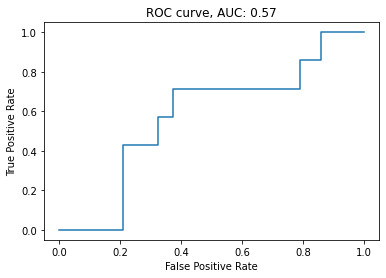

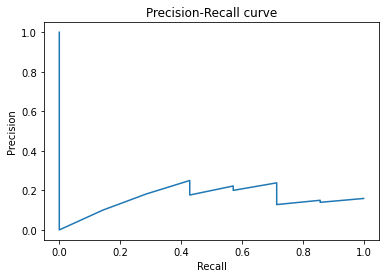

In [55]:
from toxicity.metrics import run_metrics
run_metrics(y_pred>.5, y_pred, y_valid_s, visualize=True)

In [57]:
train_history.history

{'loss': [0.39568084478378296, 0.29645344614982605, 0.2859398424625397],
 'accuracy': [0.9200000166893005, 0.9200000166893005, 0.9200000166893005],
 'val_loss': [0.41661059856414795, 0.406499981880188, 0.4096778631210327],
 'val_accuracy': [0.8600000143051147, 0.8600000143051147, 0.8600000143051147]}